In [ ]:
!unzip '/content/drive/MyDrive/PROJECTS/ZS-GZS HCR/Datasets/DatasetBangla.zip'

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import functional as Flatten
import torchvision 
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchsummary import summary

import os, glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import random

import warnings as wrn
wrn.filterwarnings('ignore')

In [ ]:
ROOT_DIR = '/content/DatasetBangla'
TRAIN_ROOT = os.path.join(ROOT_DIR, 'Train')
TEST_ROOT = os.path.join(ROOT_DIR, 'Test')
CHECKPOINT = ''

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

IMG_SIZE = (32, 32)
BATCH_SIZE = 32

N_CLASSES = len(os.listdir(TRAIN_ROOT))

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(IMG_SIZE),
    torchvision.transforms.ToTensor(),
])

train_loader = DataLoader(
    ImageFolder(TRAIN_ROOT, transform=transform),
    batch_size = BATCH_SIZE, shuffle = True, pin_memory = True, drop_last = True, num_workers = 2
)

test_loader = DataLoader(
    ImageFolder(TEST_ROOT, transform=transform),
    batch_size = BATCH_SIZE, shuffle = True, pin_memory = True, drop_last = True, num_workers = 2
)

In [ ]:
for (images, labels) in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 32, 32])
torch.Size([32])


In [ ]:
# conv out = ((i+2p-k)/s)+1
# convtrans out = (i-1)*s+k-2p

In [ ]:
class VanillaVAE(nn.Module):
    def __init__(self):
        super(VanillaVAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=2, stride=2, padding=0),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=0),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2, stride=2, padding=0),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=2, stride=1, padding=0),
            nn.LeakyReLU(),
        )

        self.fc_mu = nn.Linear(in_features=1*1*256, out_features=128)
        self.fc_var = nn.Linear(in_features=1*1*256, out_features=128)

        self.decoder_input = nn.Linear(in_features=128, out_features=1*1*256)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1*1*256, out_channels=128, kernel_size=3, stride=1, padding=0),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2, padding=0),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=0),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=0),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=0),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=2, stride=2, padding=2),
            nn.Sigmoid(),
        )
    

    ###############
    def encode(self, input):
        result = self.encoder(input) # BSx1x1x256
        result = result.view(result.size(0), -1) # BSx(1*1*256)
        mu = self.fc_mu(result) # BSx128
        log_var = self.fc_var(result) # BSx128
        return (mu, log_var)
    
    ###############
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        esp = torch.randn_like(std)
        z = mu + std * esp
        return z.to(DEVICE)
    
    ###############
    def decode(self, z):
        dec_inp = self.decoder_input(z) #BSx(1*1*256)
        dec_inp = dec_inp.view(dec_inp.size(0), 1*1*256, 1, 1) # BSx1x1x256
        recon_img = self.decoder(dec_inp)
        return recon_img 
    
    ###############
    def forward(self, img):
        mu, logvar = self.encode(img)
        z = self.reparameterize(mu, logvar)
        recon_img = self.decode(z)
        return (z, mu, logvar, recon_img)


In [ ]:
model = VanillaVAE().to(DEVICE)

In [ ]:
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
         LeakyReLU-2           [-1, 32, 30, 30]               0
            Conv2d-3           [-1, 32, 15, 15]           4,128
         LeakyReLU-4           [-1, 32, 15, 15]               0
            Conv2d-5           [-1, 64, 13, 13]          18,496
         LeakyReLU-6           [-1, 64, 13, 13]               0
            Conv2d-7             [-1, 64, 6, 6]          16,448
         LeakyReLU-8             [-1, 64, 6, 6]               0
            Conv2d-9            [-1, 128, 4, 4]          73,856
        LeakyReLU-10            [-1, 128, 4, 4]               0
           Conv2d-11            [-1, 128, 2, 2]          65,664
        LeakyReLU-12            [-1, 128, 2, 2]               0
           Conv2d-13            [-1, 256, 1, 1]         131,328
        LeakyReLU-14            [-1, 25

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 

In [ ]:
def criterion(recon_img, img, mu, logvar):
    # recon_loss = F.mse_loss(recon_img, img)
    recon_loss = F.binary_cross_entropy(recon_img, img, size_average=False)
    KLD = torch.mean(-0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp(), dim=1), dim=0)
    return recon_loss+KLD, recon_loss, KLD

In [ ]:
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    for idx, batch in enumerate(tqdm(iterator)):
        images, _ = batch
        images = images.to(DEVICE)
        optimizer.zero_grad()
        z, mu, logvar, recon_imgs = model(images)
        loss, recon_loss, kld_loss = criterion(recon_imgs, images, mu, logvar)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

In [ ]:
for epoch in range(100):
    print(f"Epoch - {epoch}")
    loss = train(model, train_loader, optimizer, criterion)
    print(f"Loss - {loss:.2f}\n")

Epoch - 0


100%|██████████| 375/375 [00:06<00:00, 56.35it/s]


Loss - 64125.90

Epoch - 1


100%|██████████| 375/375 [00:06<00:00, 55.74it/s]


Loss - 62479.19

Epoch - 2


100%|██████████| 375/375 [00:06<00:00, 57.02it/s]


Loss - 61565.83

Epoch - 3


100%|██████████| 375/375 [00:06<00:00, 56.11it/s]


Loss - 60855.15

Epoch - 4


100%|██████████| 375/375 [00:06<00:00, 56.72it/s]


Loss - 60149.29

Epoch - 5


100%|██████████| 375/375 [00:06<00:00, 56.18it/s]


Loss - 59488.81

Epoch - 6


100%|██████████| 375/375 [00:06<00:00, 56.78it/s]


Loss - 59115.67

Epoch - 7


100%|██████████| 375/375 [00:06<00:00, 55.94it/s]


Loss - 58805.93

Epoch - 8


100%|██████████| 375/375 [00:06<00:00, 56.58it/s]


Loss - 58501.39

Epoch - 9


100%|██████████| 375/375 [00:06<00:00, 55.68it/s]


Loss - 58287.80

Epoch - 10


100%|██████████| 375/375 [00:06<00:00, 55.48it/s]


Loss - 58162.31

Epoch - 11


100%|██████████| 375/375 [00:06<00:00, 56.15it/s]


Loss - 57940.25

Epoch - 12


100%|██████████| 375/375 [00:06<00:00, 56.42it/s]


Loss - 57734.62

Epoch - 13


100%|██████████| 375/375 [00:06<00:00, 56.14it/s]


Loss - 57557.09

Epoch - 14


100%|██████████| 375/375 [00:06<00:00, 56.32it/s]


Loss - 57371.83

Epoch - 15


100%|██████████| 375/375 [00:06<00:00, 56.22it/s]


Loss - 57265.10

Epoch - 16


100%|██████████| 375/375 [00:06<00:00, 55.98it/s]


Loss - 57153.06

Epoch - 17


100%|██████████| 375/375 [00:06<00:00, 55.93it/s]


Loss - 57062.78

Epoch - 18


100%|██████████| 375/375 [00:06<00:00, 56.18it/s]


Loss - 56955.18

Epoch - 19


100%|██████████| 375/375 [00:06<00:00, 56.59it/s]


Loss - 56877.20

Epoch - 20


100%|██████████| 375/375 [00:06<00:00, 55.93it/s]


Loss - 56838.68

Epoch - 21


100%|██████████| 375/375 [00:06<00:00, 54.74it/s]


Loss - 56756.27

Epoch - 22


100%|██████████| 375/375 [00:06<00:00, 55.35it/s]


Loss - 56569.93

Epoch - 23


100%|██████████| 375/375 [00:08<00:00, 43.49it/s]


Loss - 56522.55

Epoch - 24


100%|██████████| 375/375 [00:06<00:00, 55.76it/s]


Loss - 56652.55

Epoch - 25


100%|██████████| 375/375 [00:06<00:00, 56.05it/s]


Loss - 56407.89

Epoch - 26


100%|██████████| 375/375 [00:06<00:00, 55.78it/s]


Loss - 56313.29

Epoch - 27


100%|██████████| 375/375 [00:06<00:00, 55.31it/s]


Loss - 56298.74

Epoch - 28


100%|██████████| 375/375 [00:06<00:00, 55.44it/s]


Loss - 56231.07

Epoch - 29


100%|██████████| 375/375 [00:06<00:00, 55.63it/s]


Loss - 56188.03

Epoch - 30


100%|██████████| 375/375 [00:06<00:00, 55.39it/s]


Loss - 56164.94

Epoch - 31


100%|██████████| 375/375 [00:06<00:00, 55.20it/s]


Loss - 56107.12

Epoch - 32


100%|██████████| 375/375 [00:06<00:00, 55.63it/s]


Loss - 56084.07

Epoch - 33


100%|██████████| 375/375 [00:06<00:00, 55.17it/s]


Loss - 56054.96

Epoch - 34


100%|██████████| 375/375 [00:06<00:00, 55.00it/s]


Loss - 56015.45

Epoch - 35


100%|██████████| 375/375 [00:06<00:00, 55.10it/s]


Loss - 55990.63

Epoch - 36


100%|██████████| 375/375 [00:06<00:00, 55.82it/s]


Loss - 55922.43

Epoch - 37


100%|██████████| 375/375 [00:06<00:00, 54.80it/s]


Loss - 55893.29

Epoch - 38


100%|██████████| 375/375 [00:06<00:00, 55.08it/s]


Loss - 55855.15

Epoch - 39


100%|██████████| 375/375 [00:10<00:00, 35.45it/s]


Loss - 55830.92

Epoch - 40


100%|██████████| 375/375 [00:10<00:00, 37.47it/s]


Loss - 55820.41

Epoch - 41


100%|██████████| 375/375 [00:09<00:00, 41.61it/s]


Loss - 55771.56

Epoch - 42


100%|██████████| 375/375 [00:07<00:00, 48.61it/s]


Loss - 55724.35

Epoch - 43


100%|██████████| 375/375 [00:10<00:00, 35.97it/s]


Loss - 55714.18

Epoch - 44


100%|██████████| 375/375 [00:11<00:00, 34.09it/s]


Loss - 55701.87

Epoch - 45


100%|██████████| 375/375 [00:10<00:00, 35.47it/s]


Loss - 55678.73

Epoch - 46


100%|██████████| 375/375 [00:10<00:00, 35.58it/s]


Loss - 55640.75

Epoch - 47


100%|██████████| 375/375 [00:09<00:00, 38.03it/s]


Loss - 55606.89

Epoch - 48


100%|██████████| 375/375 [00:09<00:00, 41.28it/s]


Loss - 55591.01

Epoch - 49


100%|██████████| 375/375 [00:10<00:00, 36.31it/s]


Loss - 55557.22

Epoch - 50


100%|██████████| 375/375 [00:09<00:00, 38.29it/s]


Loss - 55541.42

Epoch - 51


100%|██████████| 375/375 [00:09<00:00, 38.98it/s]


Loss - 55514.42

Epoch - 52


100%|██████████| 375/375 [00:07<00:00, 51.26it/s]


Loss - 55527.43

Epoch - 53


100%|██████████| 375/375 [00:08<00:00, 44.87it/s]


Loss - 55464.70

Epoch - 54


100%|██████████| 375/375 [00:07<00:00, 48.92it/s]


Loss - 55446.13

Epoch - 55


100%|██████████| 375/375 [00:09<00:00, 37.82it/s]


Loss - 55433.81

Epoch - 56


100%|██████████| 375/375 [00:09<00:00, 41.38it/s]


Loss - 55404.24

Epoch - 57


100%|██████████| 375/375 [00:09<00:00, 41.46it/s]


Loss - 55388.38

Epoch - 58


100%|██████████| 375/375 [00:09<00:00, 40.87it/s]


Loss - 55381.52

Epoch - 59


100%|██████████| 375/375 [00:06<00:00, 54.68it/s]


Loss - 55354.82

Epoch - 60


100%|██████████| 375/375 [00:06<00:00, 54.42it/s]


Loss - 55361.67

Epoch - 61


100%|██████████| 375/375 [00:07<00:00, 51.54it/s]


Loss - 55351.28

Epoch - 62


100%|██████████| 375/375 [00:06<00:00, 54.65it/s]


Loss - 55327.20

Epoch - 63


100%|██████████| 375/375 [00:06<00:00, 54.40it/s]


Loss - 55279.12

Epoch - 64


100%|██████████| 375/375 [00:06<00:00, 54.95it/s]


Loss - 55240.08

Epoch - 65


100%|██████████| 375/375 [00:06<00:00, 54.53it/s]


Loss - 55269.16

Epoch - 66


100%|██████████| 375/375 [00:06<00:00, 55.26it/s]


Loss - 55240.36

Epoch - 67


100%|██████████| 375/375 [00:06<00:00, 55.02it/s]


Loss - 55226.58

Epoch - 68


100%|██████████| 375/375 [00:06<00:00, 54.60it/s]


Loss - 55218.78

Epoch - 69


100%|██████████| 375/375 [00:07<00:00, 48.61it/s]


Loss - 55206.41

Epoch - 70


100%|██████████| 375/375 [00:06<00:00, 54.88it/s]


Loss - 55209.40

Epoch - 71


100%|██████████| 375/375 [00:06<00:00, 54.62it/s]


Loss - 55188.48

Epoch - 72


100%|██████████| 375/375 [00:06<00:00, 54.87it/s]


Loss - 55149.77

Epoch - 73


100%|██████████| 375/375 [00:06<00:00, 53.90it/s]


Loss - 55135.27

Epoch - 74


100%|██████████| 375/375 [00:07<00:00, 53.48it/s]


Loss - 55429.67

Epoch - 75


100%|██████████| 375/375 [00:06<00:00, 54.64it/s]


Loss - 55159.77

Epoch - 76


100%|██████████| 375/375 [00:07<00:00, 52.39it/s]


Loss - 55088.15

Epoch - 77


100%|██████████| 375/375 [00:07<00:00, 53.36it/s]


Loss - 55041.60

Epoch - 78


100%|██████████| 375/375 [00:06<00:00, 55.22it/s]


Loss - 55044.22

Epoch - 79


100%|██████████| 375/375 [00:06<00:00, 54.26it/s]


Loss - 55058.27

Epoch - 80


100%|██████████| 375/375 [00:06<00:00, 53.94it/s]


Loss - 55056.39

Epoch - 81


100%|██████████| 375/375 [00:06<00:00, 54.88it/s]


Loss - 55054.13

Epoch - 82


100%|██████████| 375/375 [00:06<00:00, 54.80it/s]


Loss - 55034.61

Epoch - 83


100%|██████████| 375/375 [00:06<00:00, 54.50it/s]


Loss - 55041.38

Epoch - 84


100%|██████████| 375/375 [00:06<00:00, 55.06it/s]


Loss - 55019.55

Epoch - 85


100%|██████████| 375/375 [00:06<00:00, 54.36it/s]


Loss - 54998.47

Epoch - 86


100%|██████████| 375/375 [00:06<00:00, 54.90it/s]


Loss - 55002.32

Epoch - 87


100%|██████████| 375/375 [00:06<00:00, 55.03it/s]


Loss - 54997.23

Epoch - 88


100%|██████████| 375/375 [00:06<00:00, 54.72it/s]


Loss - 54994.29

Epoch - 89


100%|██████████| 375/375 [00:06<00:00, 54.54it/s]


Loss - 54965.50

Epoch - 90


100%|██████████| 375/375 [00:06<00:00, 54.86it/s]


Loss - 54965.77

Epoch - 91


100%|██████████| 375/375 [00:06<00:00, 55.05it/s]


Loss - 55005.30

Epoch - 92


100%|██████████| 375/375 [00:06<00:00, 54.53it/s]


Loss - 54959.36

Epoch - 93


100%|██████████| 375/375 [00:06<00:00, 54.62it/s]


Loss - 54912.25

Epoch - 94


100%|██████████| 375/375 [00:06<00:00, 54.38it/s]


Loss - 54899.38

Epoch - 95


100%|██████████| 375/375 [00:06<00:00, 54.59it/s]


Loss - 54915.65

Epoch - 96


100%|██████████| 375/375 [00:06<00:00, 54.62it/s]


Loss - 54897.15

Epoch - 97


100%|██████████| 375/375 [00:06<00:00, 54.14it/s]


Loss - 54932.60

Epoch - 98


100%|██████████| 375/375 [00:06<00:00, 54.01it/s]


Loss - 54903.13

Epoch - 99


100%|██████████| 375/375 [00:06<00:00, 54.42it/s]

Loss - 54875.23



torch.Size([32, 128]) tensor([[ 0.8698, -0.3983, -1.1060,  ...,  0.1320,  0.9469, -0.8420],
        [ 0.7929,  0.1079, -1.0245,  ...,  0.3186,  0.5060,  0.1766],
        [-0.0860, -1.1919, -2.0907,  ..., -0.3796,  0.5600,  0.2042],
        ...,
        [ 0.2908,  0.8388, -0.8042,  ..., -0.0151,  4.1679, -0.4101],
        [ 0.1875,  0.4757, -0.5077,  ..., -0.0189,  1.4018,  0.2869],
        [ 0.2325, -0.5292, -1.0224,  ...,  1.5305, -1.6353, -0.5842]],
       device='cuda:0')


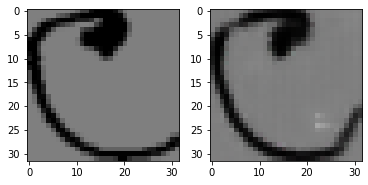

In [ ]:
model.eval()
with torch.no_grad():
    for data in random.sample(list(test_loader), 1):
        imgs, _ = data
        imgs = imgs.to(DEVICE)
        img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
        plt.subplot(121)
        plt.imshow(np.squeeze(img))
        z, mu, logvar, out = model(imgs)
        print(z.shape, z)
        outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
        plt.subplot(122)
        plt.imshow(np.squeeze(outimg))
        break

In [ ]:
import pandas as pd
from gensim.models.callbacks import CallbackAny2Vec
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

In [ ]:
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((32, 32)),
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize((0.5), (0.5)),
])

embeddings = []
for idx in range(172, 172+50):
    img_path = f'/content/DatasetBangla/Test/{idx}/bcc000020.bmp'
    img = test_transform(cv2.imread(img_path))
    # print(img.shape)

    z, mu, logvar, out = model(img.unsqueeze(0).to(DEVICE))
    embd = z
    embd = embd.view(-1, embd.shape[1])
    # print(embd.shape, recon.shape)
    embeddings.append(list(embd[0].cpu().detach().numpy()))   

np.array(embeddings).shape

(50, 128)

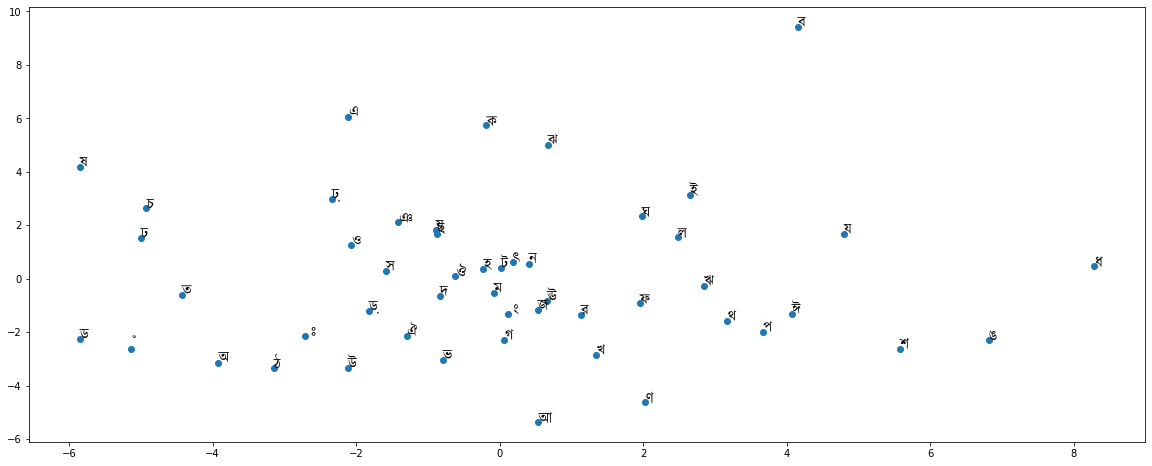

In [ ]:
prop = fm.FontProperties(fname='/content/drive/MyDrive/PROJECTS/ZS-GZS HCR/required files/kalpurush.ttf')

X = embeddings
pca = PCA(n_components=2)
result = pca.fit_transform(X)

plt.figure(figsize=(20, 8))
plt.scatter(result[:, 0], result[:, 1])

chars = [
    'অ', 'আ', 'ই', 'ঈ', 'উ', 'ঊ', 'ঋ', 'এ', 'ঐ', 'ও', 'ঔ', 'ক', 'খ', 'গ', 'ঘ', 'ঙ', 'চ', 'ছ', 'জ', 'ঝ', 'ঞ', 'ট', 'ঠ', 'ড', 
    'ঢ', 'ণ', 'ত', 'থ', 'দ', 'ধ', 'ন', 'প', 'ফ', 'ব', 'ভ', 'ম', 'য', 'র', 'ল', 'শ', 'ষ', 'স', 'হ', 'ড়', 'ঢ়', 'য়', 'ৎ',' ং',' ঃ', ' ঁ',
    # 'অনুস্বার','বিসর্গ', 'চন্দ্রবিন্দু'
]

for i, char in enumerate(chars):
    plt.annotate(
        char,
        xy = (result[i, 0], result[i, 1]),
        fontproperties=prop,
        fontsize=15
    )

plt.show()

In [ ]:
embeddings = []
for idx in range(172, 172+50):
    img_path = f'/content/DatasetBangla/Train/{idx}/'
    imgs_paths = glob.glob(os.path.join(img_path, '*.*'))
    
    embeds = 0
    for img_path in imgs_paths:
        img = test_transform(cv2.imread(img_path))
        z, mu, logvar, out = model(img.unsqueeze(0).to(DEVICE))
        embd = z.cpu().detach().numpy().squeeze()
        embeds += embd
    
    embeds = embeds / len(imgs_paths)
    # print(embeds.shape, embeds)
    embeddings.append(embeds)

np.array(embeddings).shape

(50, 128)

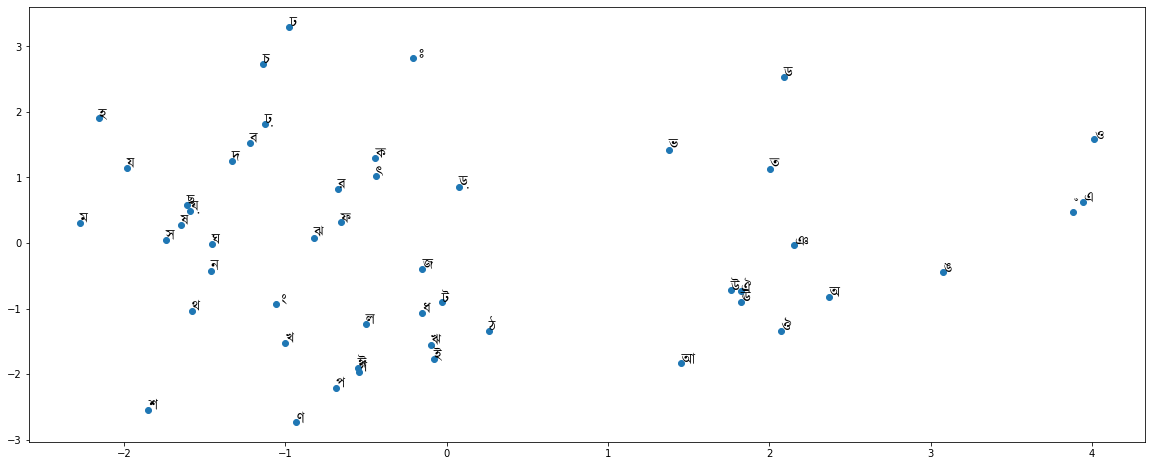

In [ ]:
prop = fm.FontProperties(fname='/content/drive/MyDrive/PROJECTS/ZS-GZS HCR/required files/kalpurush.ttf')

X = embeddings
pca = PCA(n_components=2)
result = pca.fit_transform(X)

plt.figure(figsize=(20, 8))
plt.scatter(result[:, 0], result[:, 1])

chars = [
    'অ', 'আ', 'ই', 'ঈ', 'উ', 'ঊ', 'ঋ', 'এ', 'ঐ', 'ও', 'ঔ', 'ক', 'খ', 'গ', 'ঘ', 'ঙ', 'চ', 'ছ', 'জ', 'ঝ', 'ঞ', 'ট', 'ঠ', 'ড', 
    'ঢ', 'ণ', 'ত', 'থ', 'দ', 'ধ', 'ন', 'প', 'ফ', 'ব', 'ভ', 'ম', 'য', 'র', 'ল', 'শ', 'ষ', 'স', 'হ', 'ড়', 'ঢ়', 'য়', 'ৎ',' ং',' ঃ', ' ঁ',
    # 'অনুস্বার','বিসর্গ', 'চন্দ্রবিন্দু'
]

for i, char in enumerate(chars):
    plt.annotate(
        char,
        xy = (result[i, 0], result[i, 1]),
        fontproperties=prop,
        fontsize=15
    )

plt.show()